In [1]:
import numpy as np
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.mixture import GaussianMixture
import cv2 as cv
import os
from PIL import Image
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
class DeepLab:
    
    def __init__(self, selected_layer=405):
        from model import Deeplabv3
        import tensorflow as tf
        
        self.model = Deeplabv3(weights="pascal_voc", input_shape=(360, 640, 3), backbone="xception", classes=21)
        self.model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        outputs = [layer.output for layer in self.model.layers]
        self.model = tf.keras.models.Model(inputs=self.model.inputs, outputs=outputs)
        
        for layer in self.model.layers: layer.trainable = False
        self.image_list = []
        self.selected_layer = selected_layer

    def preprocess_image(self, image):
        image = resize(image, (360, 640), anti_aliasing=True)
        image = np.expand_dims(image, axis=0)
        return image

    def get_features(self):
        feature_list = []
        for img in self.image_list:
            feature_map = self.model.predict(img)[self.selected_layer]
            feature_list.append(feature_map)
        return np.array(feature_list)
    
    def predict(self, image):
        image = self.preprocess_image(image)
        return self.model.predict(image)[self.selected_layer]

In [3]:
def deeplab_prediction(image_name):
    from model import Deeplabv3

    # Generates labels using most basic setup.  Supports various image sizes.  Returns image labels in same format
    # as original image.  Normalization matches MobileNetV2

    trained_image_width=512 
    mean_subtraction_value=127.5
    image = np.array(Image.open(image_name))

    # resize to max dimension of images from training dataset
    w, h, _ = image.shape
    ratio = float(trained_image_width) / np.max([w, h])
    resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

    # apply normalization for trained dataset images
    resized_image = (resized_image / mean_subtraction_value) - 1.

    # pad array to square image to match training images
    pad_x = int(trained_image_width - resized_image.shape[0])
    pad_y = int(trained_image_width - resized_image.shape[1])
    resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

    # make prediction
    deeplab_model = Deeplabv3()
    res = deeplab_model.predict(np.expand_dims(resized_image, 0))
    labels = np.argmax(res.squeeze(), -1)

    # remove padding and resize back to original image
    if pad_x > 0:
        labels = labels[:-pad_x]
    if pad_y > 0:
        labels = labels[:, :-pad_y]
    labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

    return labels

In [4]:
def get_binary(class_image):
    numclasses = len(np.unique(class_image))
    heuristic = [0] * numclasses

    for k in range(numclasses):
        tt = (class_image == k)
        tt2 = np.where(tt)
        xs = np.abs(tt2[0] - np.round(class_image.shape[0]/2))
        ys = np.abs(tt2[1] - np.round(class_image.shape[1]/2))
        heuristic[k] = np.sqrt(np.mean(xs)**2 + np.mean(ys)**2)
        
    foreground_class = np.argmin(heuristic)
    outseg = np.zeros([class_image.shape[0], class_image.shape[1]])
    tt = np.zeros_like(class_image)

    tt[class_image == foreground_class] = 0xff
    tt[class_image != foreground_class] = 0x00
    outseg = tt
    return outseg.astype(int)

In [5]:
def IoU(ground_truth, prediction):
    if(ground_truth.shape != prediction.shape):
        prediction = np.array(Image.fromarray(prediction.astype('uint8')).resize(ground_truth.T.shape))
    prediction = (prediction == 255) * prediction / 255
    
    intersection = np.logical_and(get_binary(ground_truth), get_binary(prediction))
    union = np.logical_or(get_binary(ground_truth), get_binary(prediction))
    return np.sum(intersection) / np.sum(union)

In [6]:
deeplab = DeepLab()
pca = PCA(n_components=8)

In [7]:
gmm_6 = GaussianMixture(n_components=6, covariance_type='tied')
gmm_4 = GaussianMixture(n_components=4, covariance_type='tied')

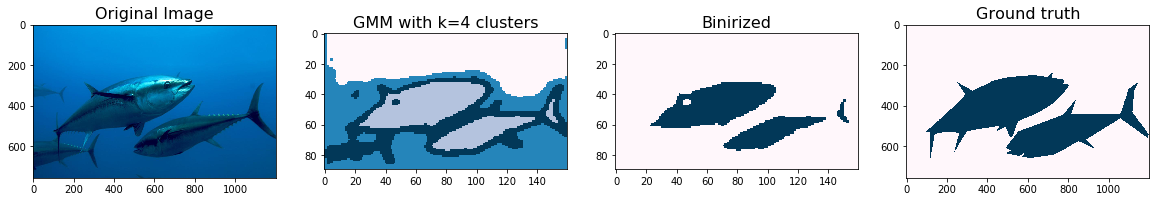

Intersection over Union: 0.6115649805898372


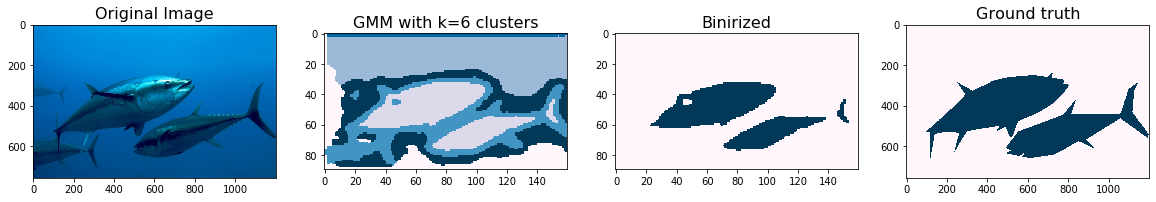

Intersection over Union: 0.6099428880664083


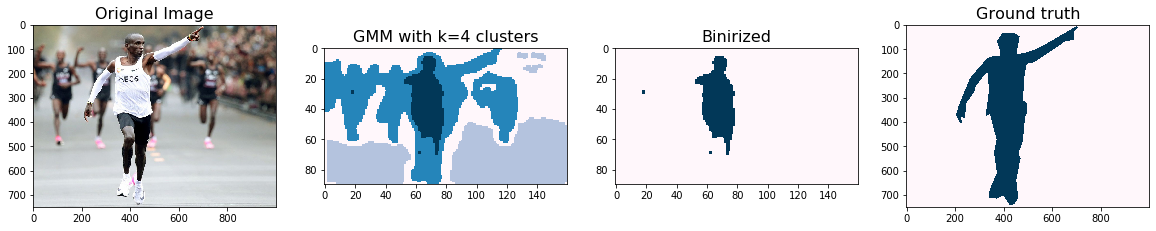

Intersection over Union: 0.43508474909935624


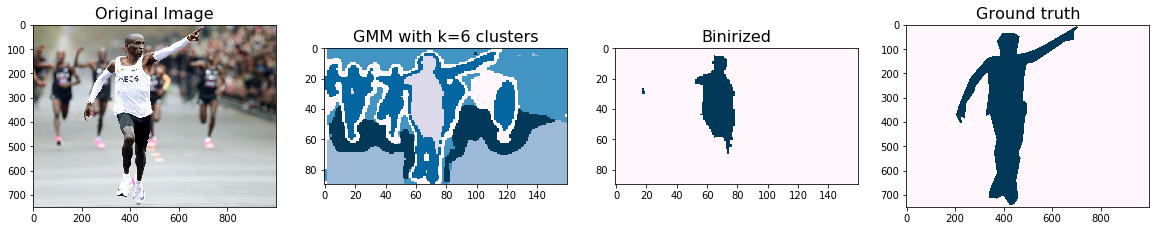

Intersection over Union: 0.42737221249040486


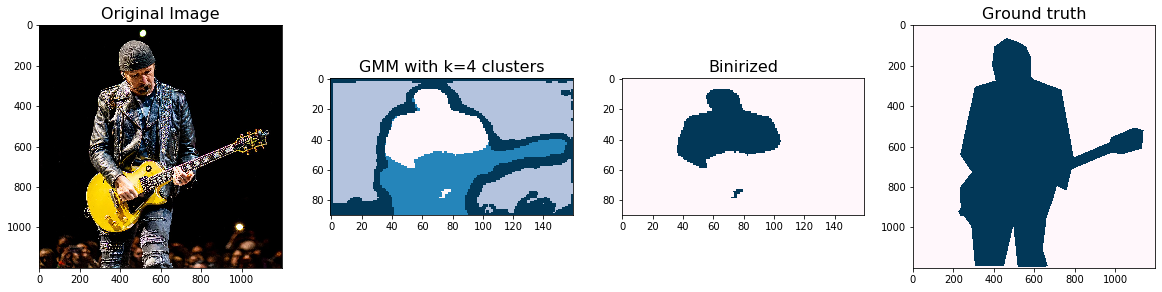

Intersection over Union: 0.41838247899879993


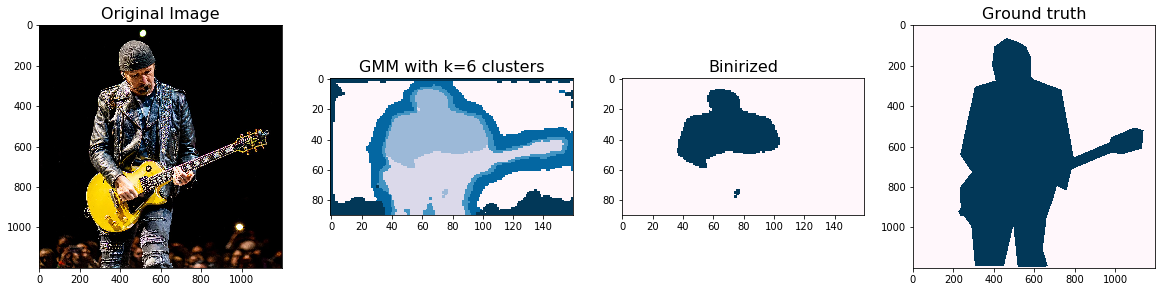

Intersection over Union: 0.41189849353837177


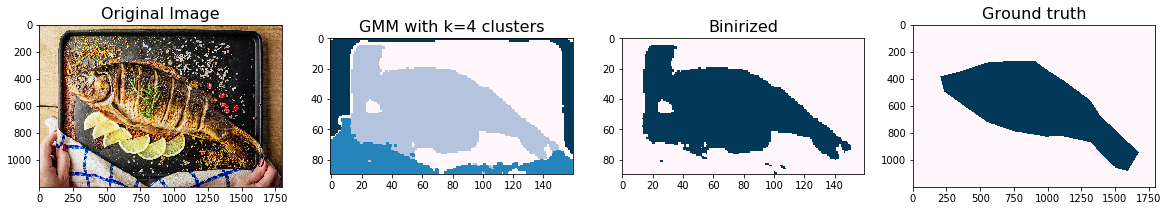

Intersection over Union: 0.604644157332677


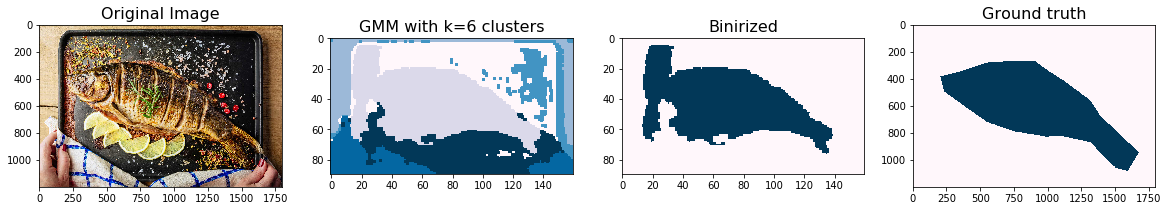

Intersection over Union: 0.6810983301123673


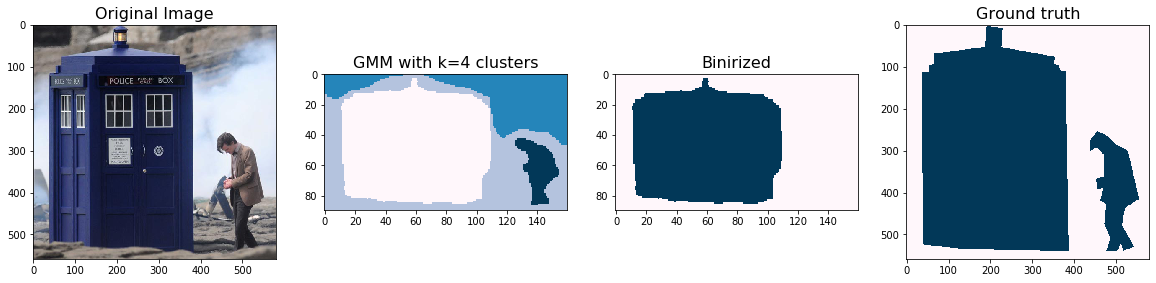

Intersection over Union: 0.7999879843140681


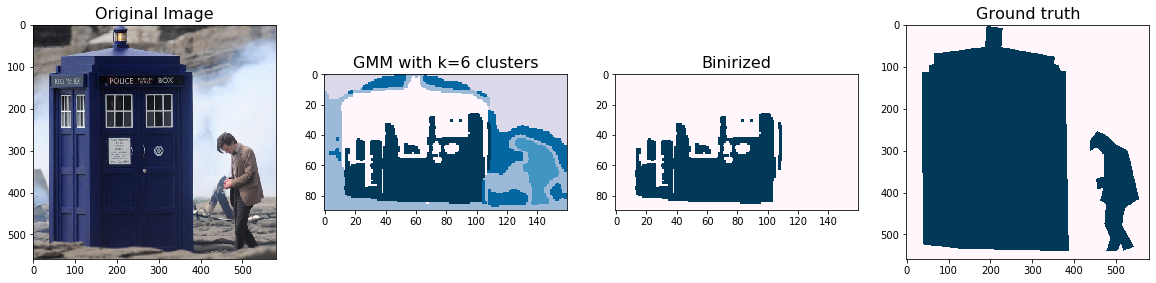

Intersection over Union: 0.39196584878256213


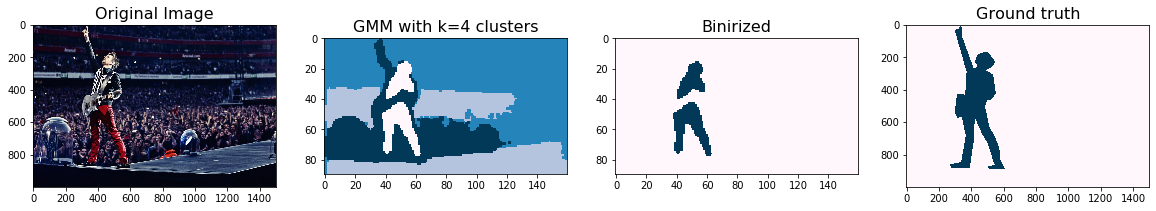

Intersection over Union: 0.450807263324141


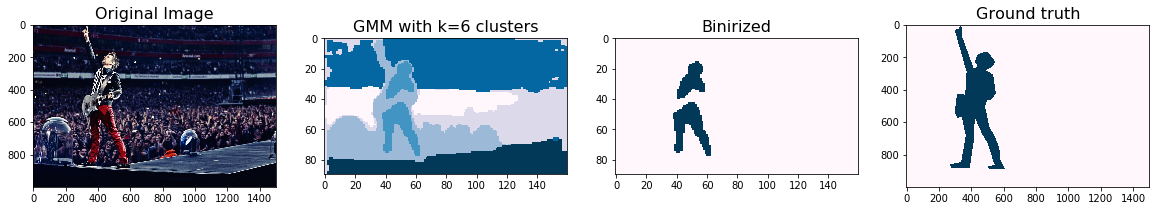

Intersection over Union: 0.4503691079958378


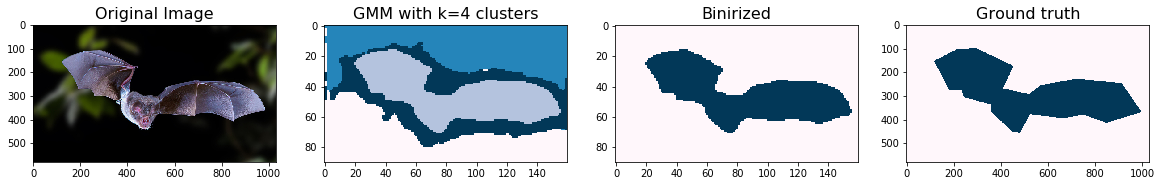

Intersection over Union: 0.8590393001029667


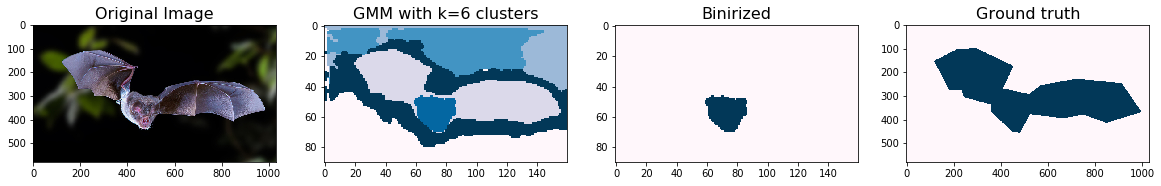

Intersection over Union: 0.12144306748996071


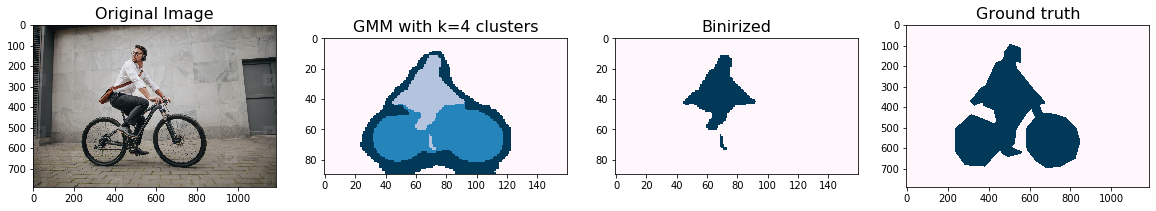

Intersection over Union: 0.30483875349797596


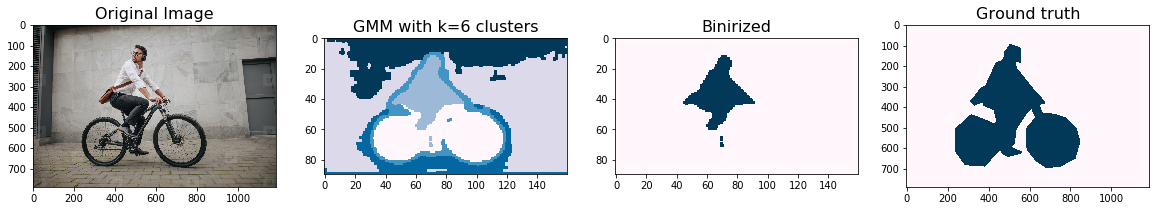

Intersection over Union: 0.3001766900071985


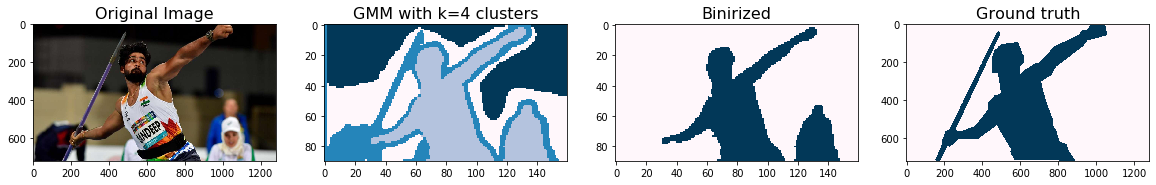

Intersection over Union: 0.572933309028783


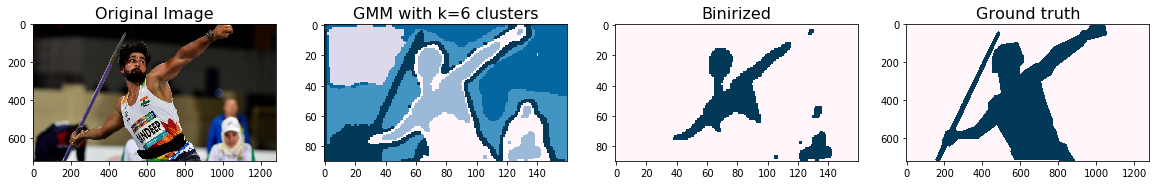

Intersection over Union: 0.33676770097040853


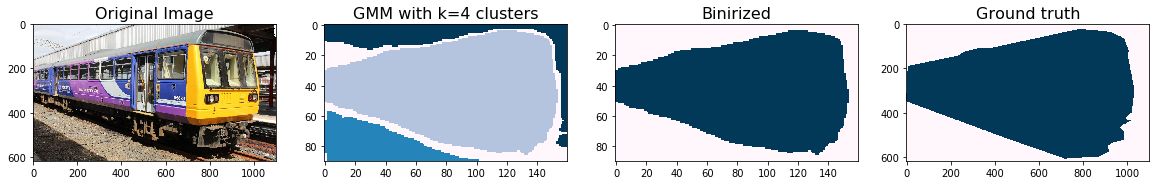

Intersection over Union: 0.9073649919938248


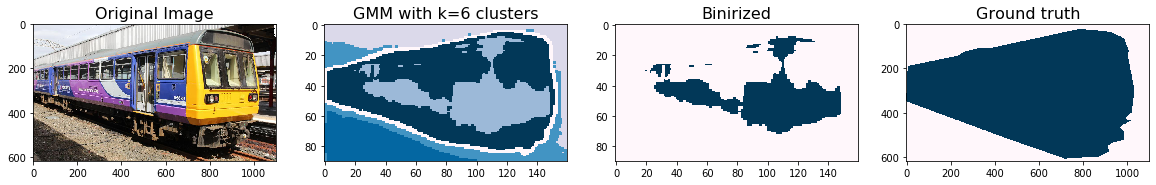

Intersection over Union: 0.274698377988649


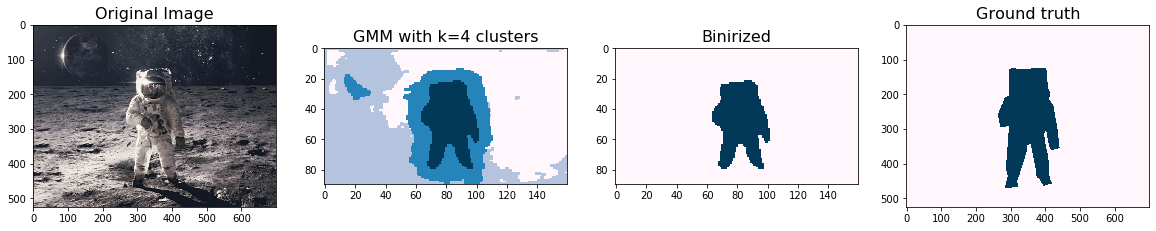

Intersection over Union: 0.7498835367557999


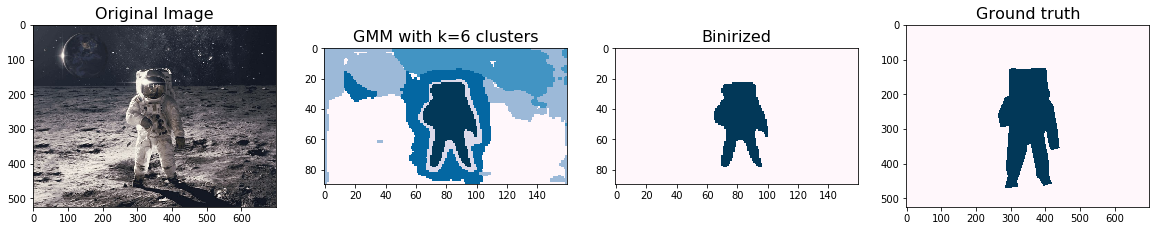

Intersection over Union: 0.6797689558960301


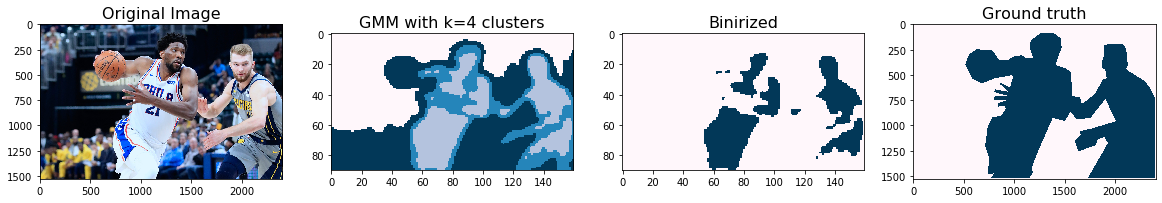

Intersection over Union: 0.379664817331856


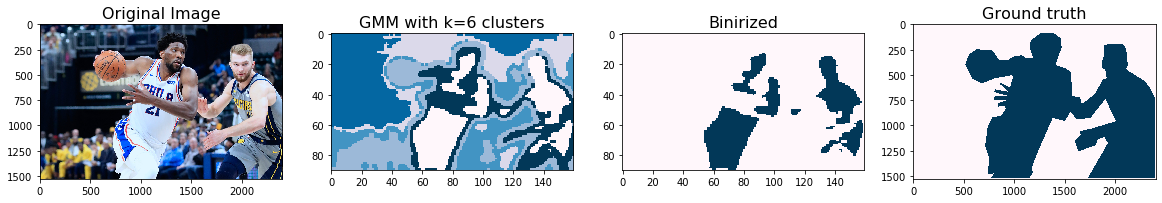

Intersection over Union: 0.3329856171133969


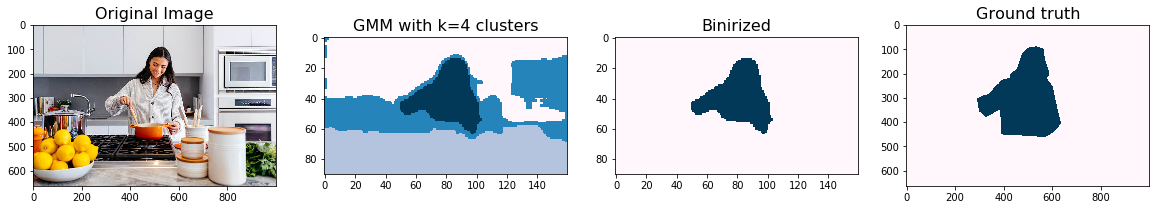

Intersection over Union: 0.6956276410327144


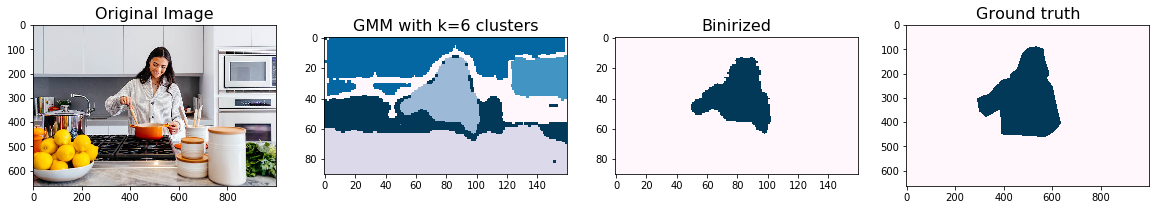

Intersection over Union: 0.7068679870472174


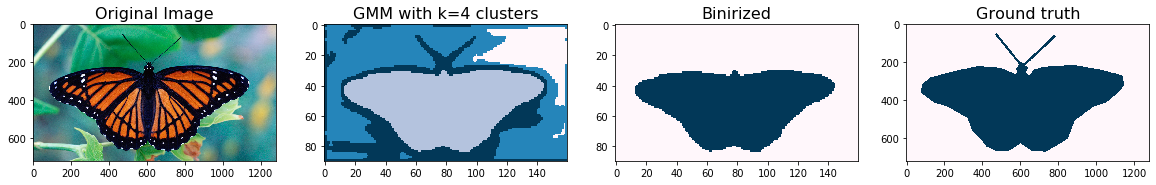

Intersection over Union: 0.8537287030717768


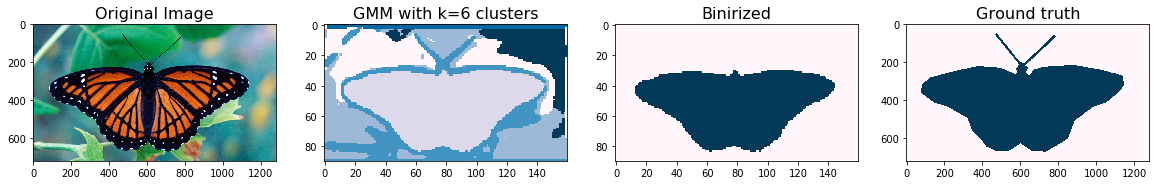

Intersection over Union: 0.8527841950131443


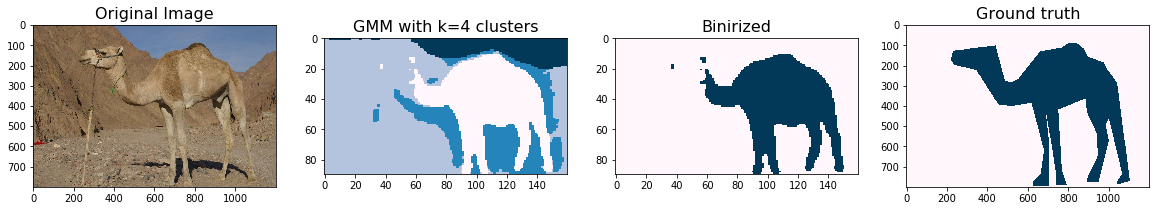

Intersection over Union: 0.6031053452382993


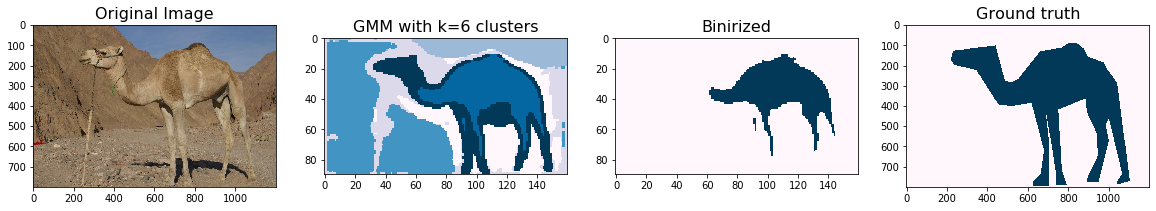

Intersection over Union: 0.4843435747338817


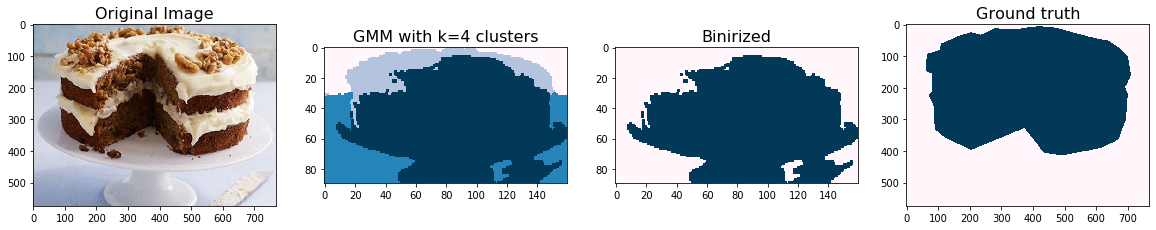

Intersection over Union: 0.4965992670450207


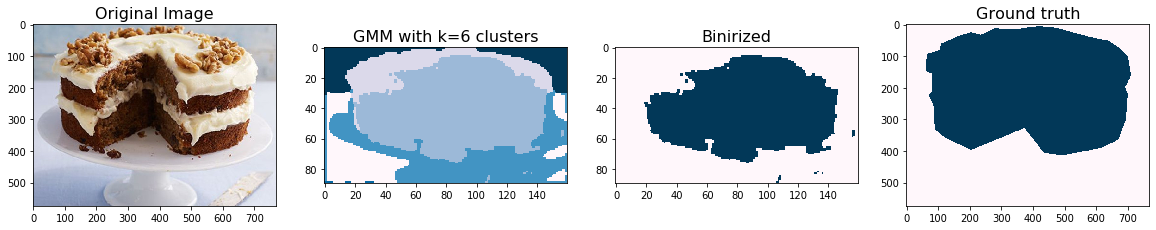

Intersection over Union: 0.6489055395134256


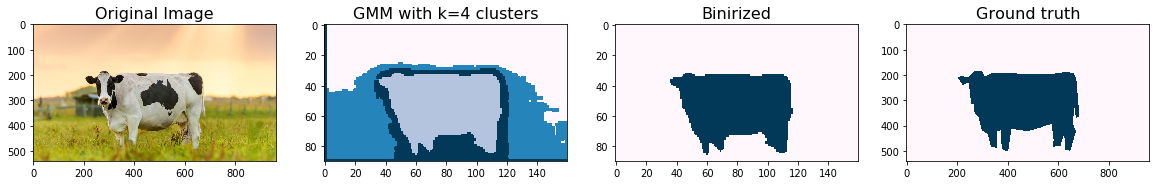

Intersection over Union: 0.830847313504225


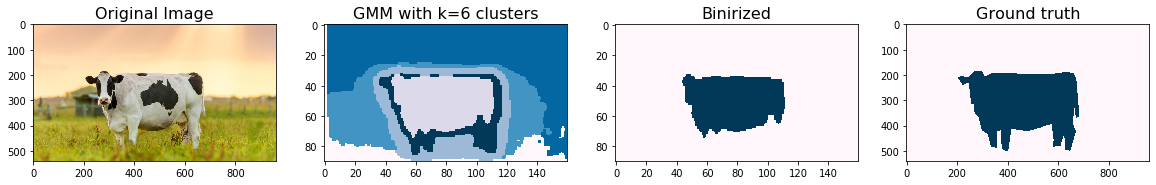

Intersection over Union: 0.699457051920026


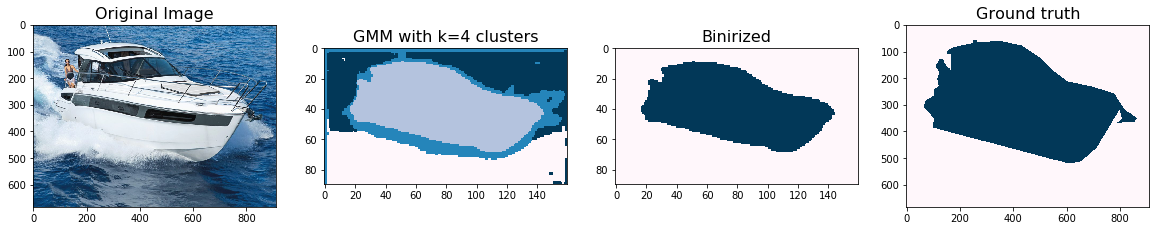

Intersection over Union: 0.8673656159995693


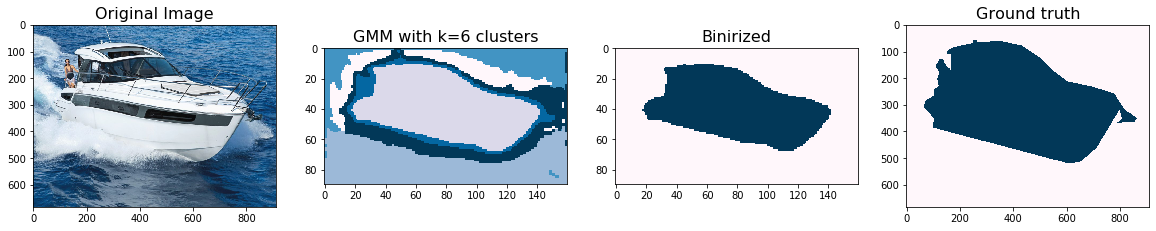

Intersection over Union: 0.7966702970431262


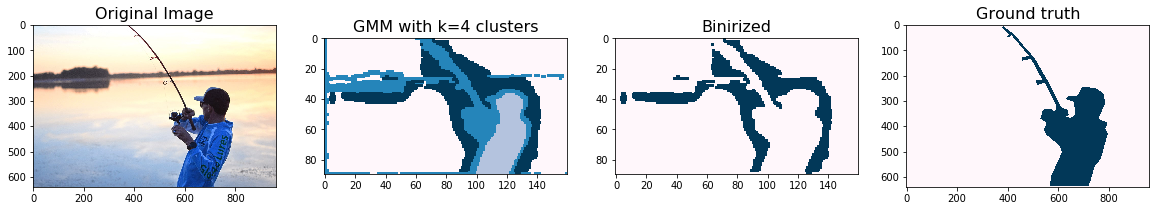

Intersection over Union: 0.0021816590610739513


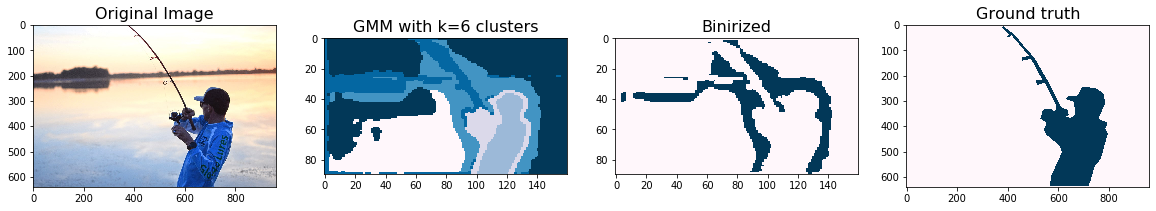

Intersection over Union: 0.0055103145168741005


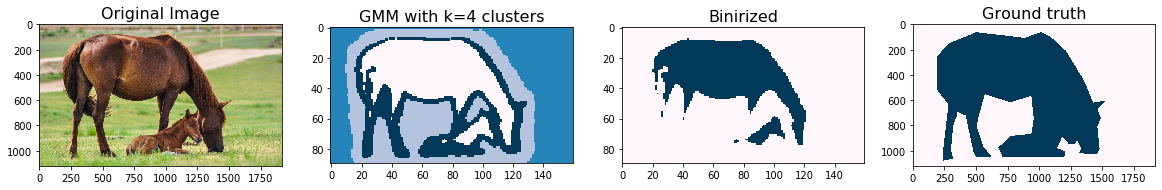

Intersection over Union: 0.5329242805175985


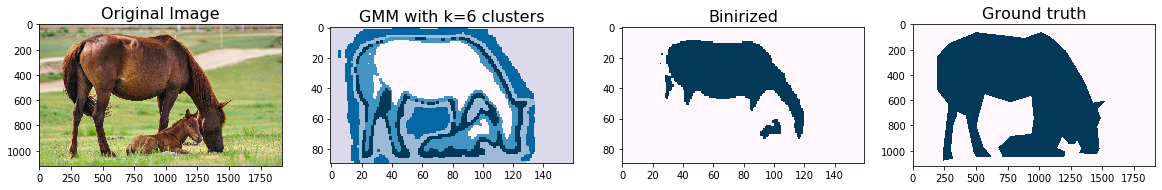

Intersection over Union: 0.45833634276057916


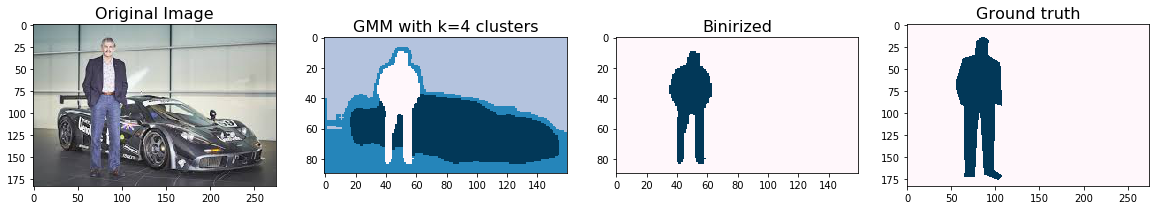

Intersection over Union: 0.6772199325590109


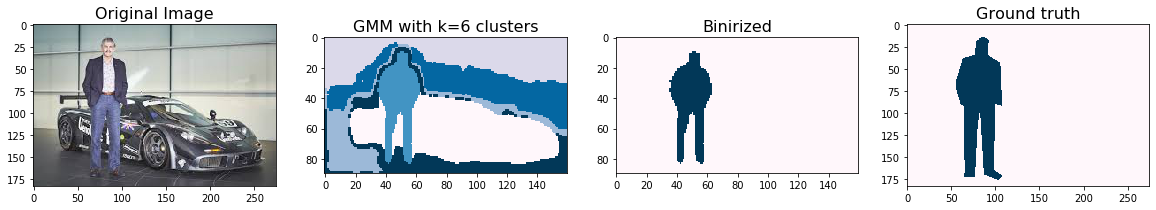

Intersection over Union: 0.6596103409516673


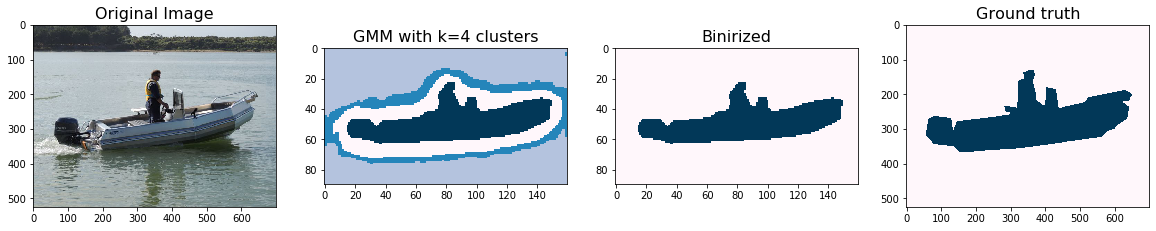

Intersection over Union: 0.8122941664996134


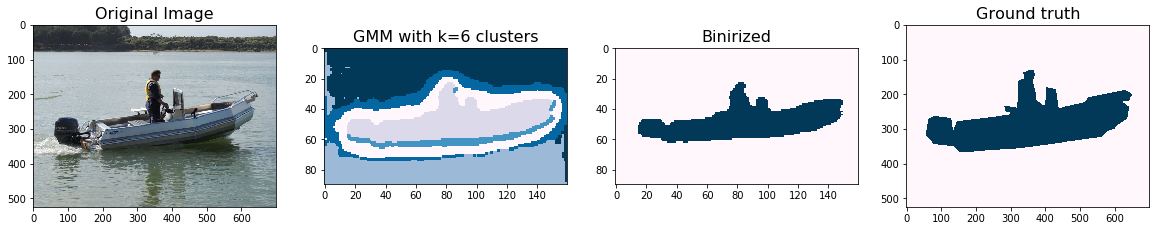

Intersection over Union: 0.8222113618861442


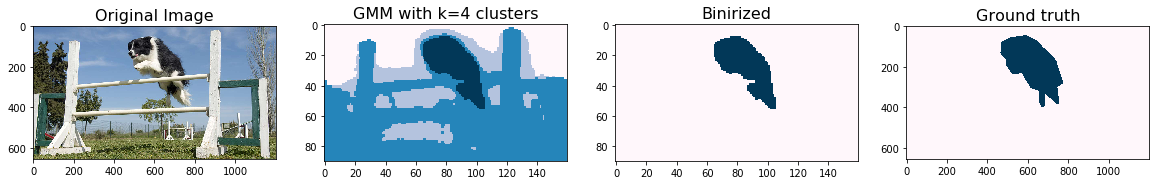

Intersection over Union: 0.7187589045432958


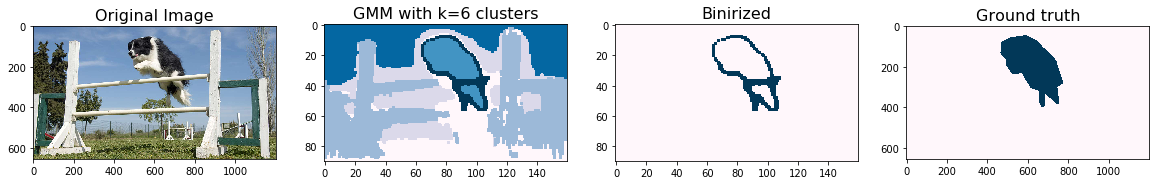

Intersection over Union: 0.14687188341941917


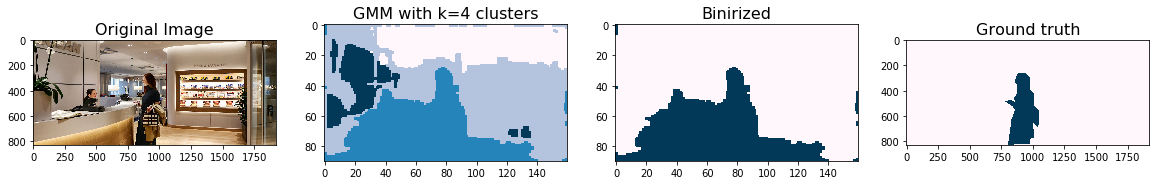

Intersection over Union: 0.21132585188831576


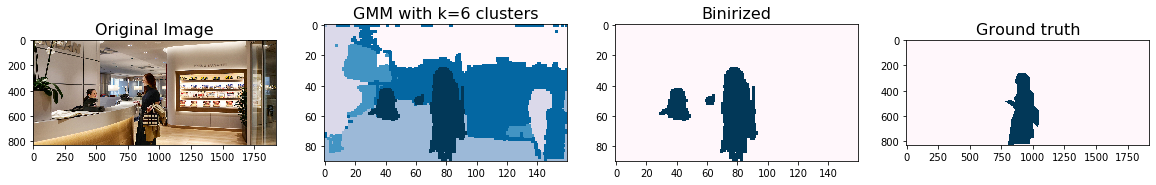

Intersection over Union: 0.513066429728741


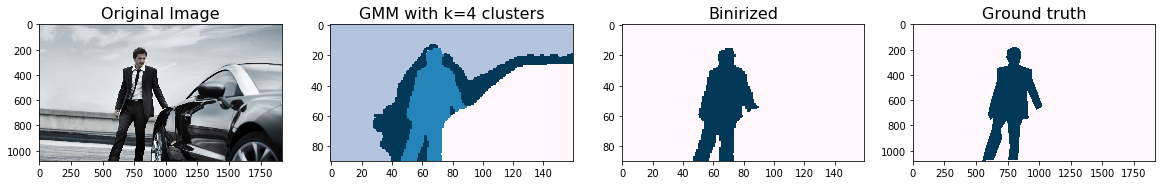

Intersection over Union: 0.6954505125402031


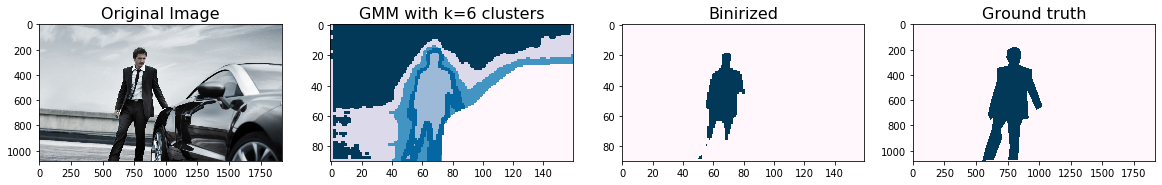

Intersection over Union: 0.5058039261283259


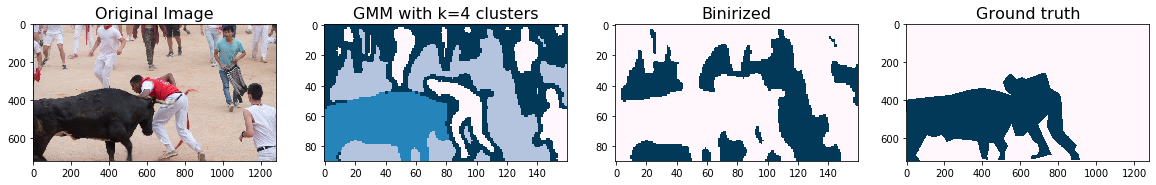

Intersection over Union: 0.007142669837600579


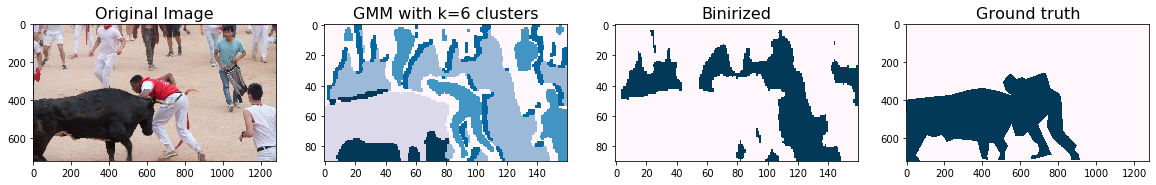

Intersection over Union: 0.0011848476477692219


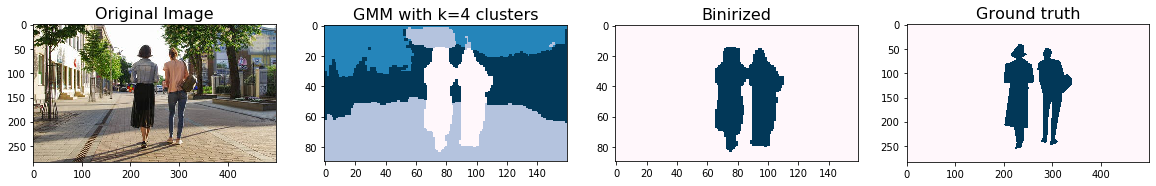

Intersection over Union: 0.6287923854848304


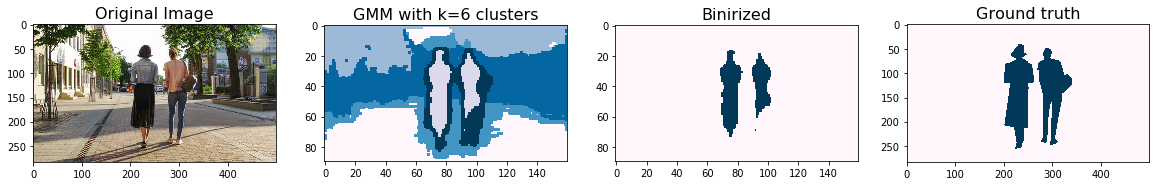

Intersection over Union: 0.4396003633060854


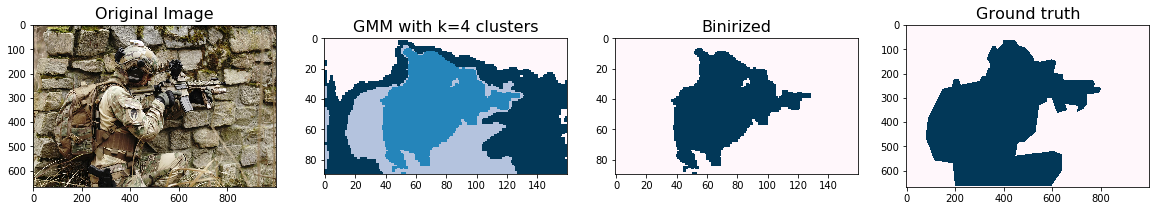

Intersection over Union: 0.5417453502801779


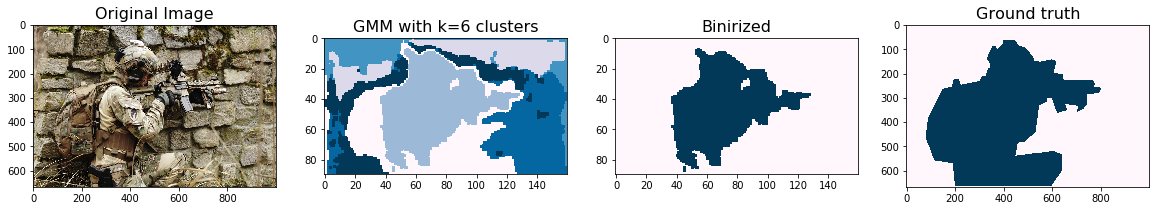

Intersection over Union: 0.5435797108733728


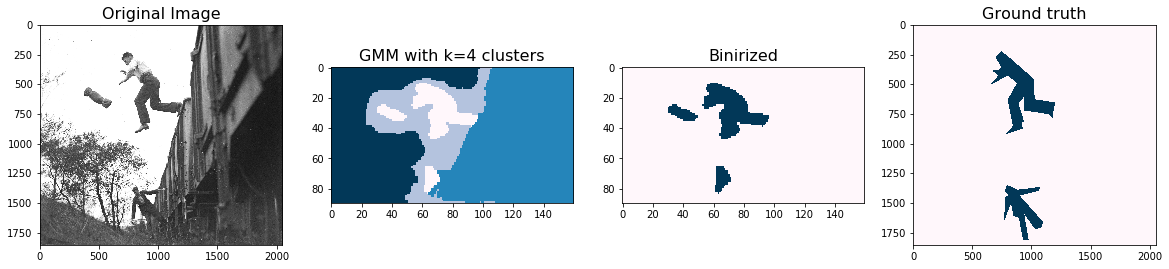

Intersection over Union: 0.45427222437546244


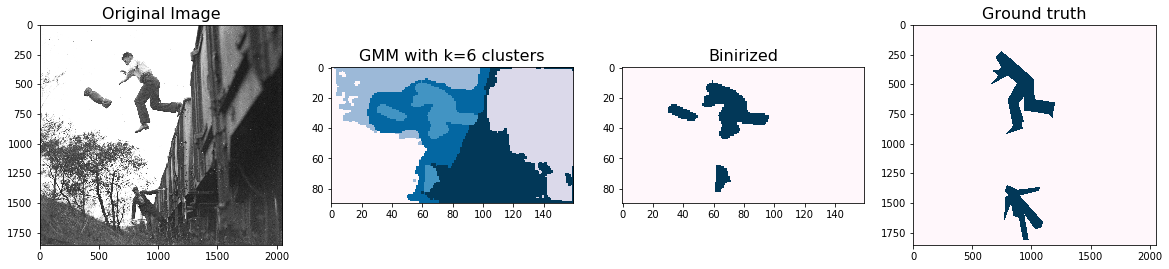

Intersection over Union: 0.460432090192685


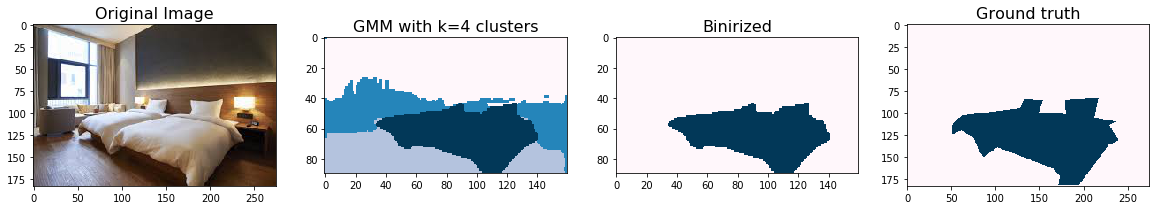

Intersection over Union: 0.8026706231454006


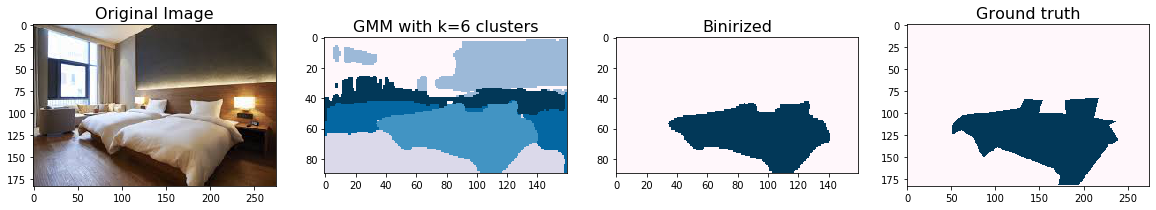

Intersection over Union: 0.8086498273668908


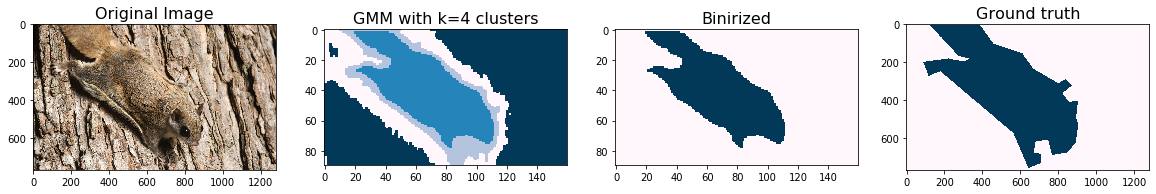

Intersection over Union: 0.7415999797131586


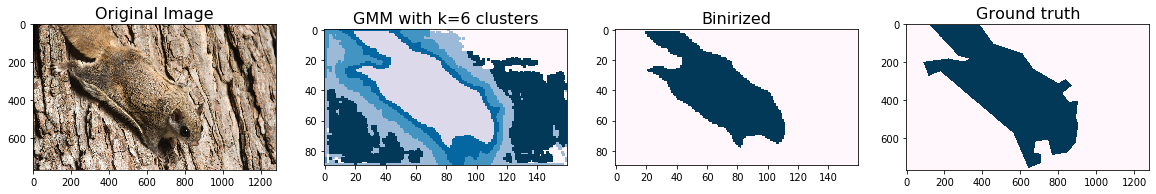

Intersection over Union: 0.7362058534782876


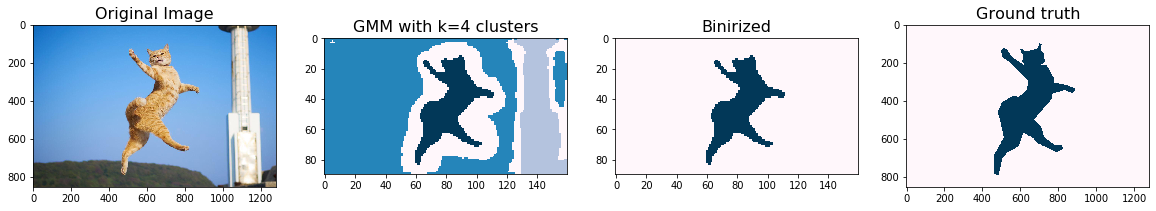

Intersection over Union: 0.7063458514397795


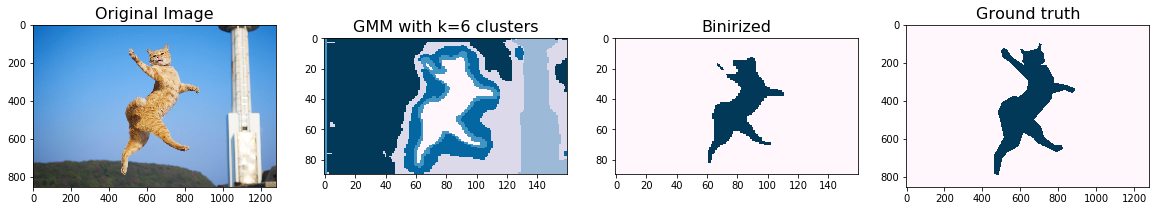

Intersection over Union: 0.6581713865906348


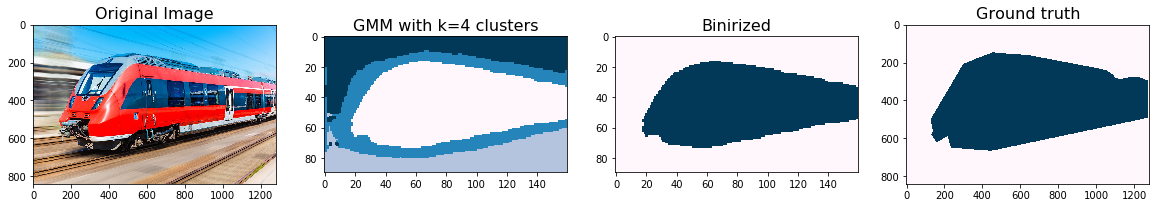

Intersection over Union: 0.8927818255871838


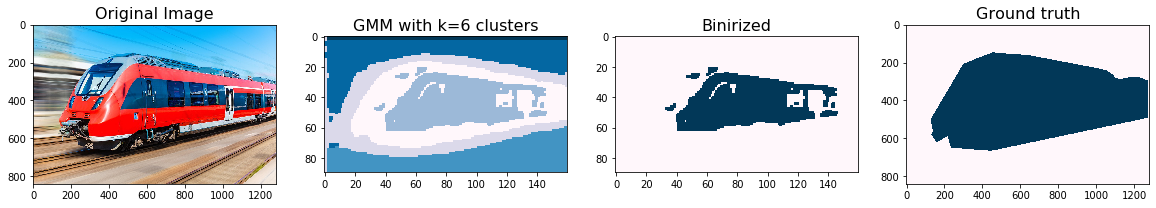

Intersection over Union: 0.4206641626991404


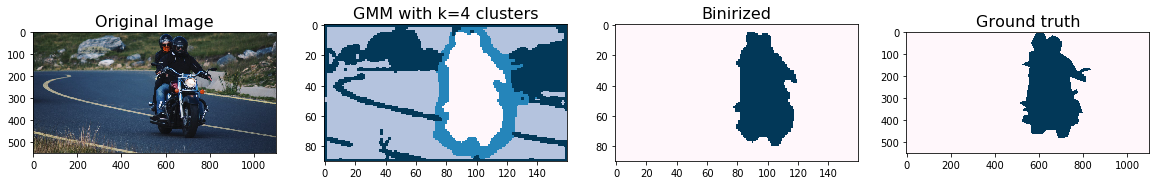

Intersection over Union: 0.8141552746969306


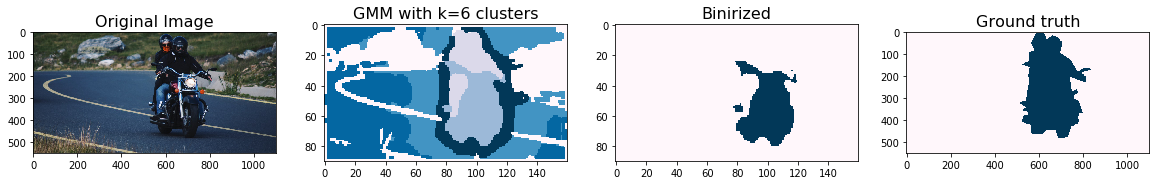

Intersection over Union: 0.4682189145298261


In [8]:
i = 1
os.makedirs('figures_4')
os.makedirs('figures_6')

for name in glob.glob('C:\\Users\\me\\Desktop\\praconbe-datasets\\victorvarious\\*'):
    if name.endswith('.jpg'):
        img = plt.imread(name)
        deeplab_pred = deeplab_prediction(name)
        continue
    else:
        A = np.load(name)
        building_annotation = A['annotation_matrix'][:, :, 0]
        
    features = deeplab.predict(img)
    n, w, h, d = features.shape
    reduced_features = pca.fit_transform(features.reshape(-1, d))

    pred_4 = gmm_4.fit_predict(reduced_features.reshape(-1, 8)).reshape(90, 160)
    pred_6 = gmm_6.fit_predict(reduced_features.reshape(-1, 8)).reshape(90, 160)
    
    pred_filtered_4 = cv.morphologyEx(pred_4.astype(float), cv.MORPH_OPEN, np.ones((2,2)))
    pred_filtered_6 = cv.morphologyEx(pred_6.astype(float), cv.MORPH_OPEN, np.ones((2,2)))
    
    binarized_4 = get_binary(pred_filtered_4)
    binarized_6 = get_binary(pred_filtered_6)

    plt.subplot(1,4,1)
    plt.title('Original Image', fontsize=16)
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title('GMM with k=4 clusters', fontsize=16)
    plt.imshow(pred_filtered_4, cmap='PuBu')
    plt.subplot(1,4,3)
    plt.title('Binirized', fontsize=16)
    plt.imshow(binarized_4, cmap='PuBu')
    plt.subplot(1,4,4)
    plt.title('Ground truth', fontsize=16)
    plt.imshow(building_annotation, cmap='PuBu')
    plt.savefig('figures_4\\figure {}.jpg'.format(i), bbox_inches='tight')
    plt.show()
    print('Intersection over Union: {}'.format(IoU(building_annotation, binarized_4)))
    
    plt.subplot(1,4,1)
    plt.title('Original Image', fontsize=16)
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title('GMM with k=6 clusters', fontsize=16)
    plt.imshow(pred_filtered_6, cmap='PuBu')
    plt.subplot(1,4,3)
    plt.title('Binirized', fontsize=16)
    plt.imshow(binarized_6, cmap='PuBu')
    plt.subplot(1,4,4)
    plt.title('Ground truth', fontsize=16)
    plt.imshow(building_annotation, cmap='PuBu')
    plt.savefig('figures_6\\figure {}.jpg'.format(i), bbox_inches='tight')
    plt.show()
    print('Intersection over Union: {}'.format(IoU(building_annotation, binarized_6)))
    
    i += 1